# Simulate a pair of phyllotaxis sequence
This notebook shows you how to simulate a pair of "phyllotaxis" sequences.
- a phyllotaxis sequence is an ordered sequence of values representing the divergence angles and internode length between 'organs' (e.g. leaves, fruits, flowers, branches) along the stem of a plant
- a pair of sequences are two related sequences: one "reference" and one "test" derived from the "reference" after several modifications.

## Upload the libraries

In [2]:
source("../../source/sim_phyllo_sources.R")
source("../../source/plot_sequences_sources.R")

## Define the main characteristics of the paired sequence

In [3]:
N=19 #Number of intervals in the sequence (which contains N+1 organs)
alpha=137.5 #the average value of divergence angles (137°5 is the value for Fibonacci spiral phyllotaxis)
a_sd=18.5 #biological/natural gaussian noise on angle values
i_Gsd=0.8 #biological/natural gaussian noise on internode values
i_noise_pct=75 #scale the biological/natural noise on internode relative to the average internode length
seq=make_refseq(N=N, alpha=alpha, a_sd=a_sd,
                     i_Gsd=i_Gsd, i_noise_pct=i_noise_pct,
                     verbose=TRUE)
align_init=make_align_list(N)
#head(align_init)

#Note: several other parameters are accessible to adjust the parameter of the sequences (both angles and internodes).
#Informations about these parameters are printed in the terminal when verbose mode is on.
#Here is the list of all the parameters with the default values for each (adjusted to match real data in Arabidopsis thaliana):

#N: length of the sequence
#alpha=137.5, a_sd=30 : mean/sd divergence angle value (Gaussian dist.)
# natural.permutation=TRUE, permutation.frequency=0.04: whether natural permutations exists (causing stereotypical patterned variations in divergence angles), and the frequency at which they occur (model as a binomial distribution in the sequence)
#i_Gsd=1.5, i_noise_pct=75: (INTERNODES)
#i_beta=1.5, i_max=100, i_plateau=5: (INTERNODES) exponential decay of the internode length, Maximum internode length (in mm), average value towards which the internodes are converging (in mm)
                     

[1] "Natural permutations can be added to the divergence angle sequence"
[1] "there are isolated permutations"
[1] "No consecutive permutations have been drawn in the sequence"
[1] "Computing new divergence angles after natural permutations"


## Choose the scenario of the paired sequence

Differences between reference & test sequences come either from segmentation errors, permutations or noise on values:

- *segmentation error*: a 'reference' organ is added or removed
- *permutation*: the order of two organs in the reference is permuted in the matching order of the test sequence. This only happens for organs separated by short internode length.
- *noise*: a noise is applied on divergence angles and internode length values.

Two different relationships between the 'reference' and 'test' can be simulated: 

- the test sequence is generated directly from the reference sequence
- the test and the reference sequences are both generated from the same initial sequence. This simulates an experimental scenario where the initial sequence is the (inacessible) theoretical biological reality, while 'reference' and 'test' are both measurements of the initial sequence. 'Reference' is the validated measurement method, which is used to compare an alternative 'test' measurement method.


In [4]:
##Main parameters of the scenario
seg_errors=TRUE #whether the initial seq will be affected or not by segmentation errors
permutation=FALSE #whether close organs can be permuted in the test sequence only
Noise_or_Measures="Measures" #[Noise or Measures]
#Explanation: "Noise": test sequence is derived from ref seq with noise ; 
#             "Measures": both ref and test sequences are a measure (with "noise") of the same sequence.

## Define precisely how test sequence diverge from reference sequence

In [10]:
#Depending on the main parameters of the scenario activated above, other parameters should be specified
    ## Segmentation Errors: 
if (seg_errors){
    GAIN=c(1,1,15,21,21,21) #indicate the indices of organs that have been added in the 'test' sequence
    LOSS=c(1,2,3,8,18,19,20) #indicate the indices of organs that have been lost in the 'test' sequence 
  }

    ## Measurement Permutations: 
if (permutation){
    #Permutation will be applied to each possible situations depending on selected scenario: measurement (hence only automated measurement), noisy seq, seq with only segmentation errors
    permut_length=2 #maximum length (in mm) of an internode whose organ pair is susceptible to be permuted
    permut_proba=1 #proba to make a permut when it is possible
  }

    ## 'dual measurement' scenario: 
if (Noise_or_Measures == "Measures"){
    #E.g.: Meas1 is a manual measurement, Meas2 is an automated computer measurement
    Meas1_anoise_sd=6 #(in degree, noise with gaussian distrib. of zero mean)
    Meas1_inoise_sd=0.5 #(in mm, noise with gaussian distrib. of zero mean)
    Meas2_anoise_sd=20 #(in degree, noise with gaussian distrib. of zero mean)
    Meas2_inoise_sd=5 # -> x 10 manual
  }

if (Noise_or_Measures == "Noise"){
    sd_noise_level = c(0.5, 0.5) #range [0; +Inf]
    sd_noise_scale = "sd" # ["sd", "mean" or "absolute"]
    mean_noise_bias = c(0, 0) #range [0; +Inf]
  }

## Generate the sequences

In [11]:
if (Noise_or_Measures == "Measures"){
    #The two paired sequences are both a measure
    seq.ref=make_measure(seq, anoise_sd = Meas1_anoise_sd, inoise_sd = Meas1_inoise_sd, 
                         noise.scale = "absolute", verbose=TRUE)
    seq.aut=make_measure(seq, anoise_sd = Meas2_anoise_sd, inoise_sd = Meas2_inoise_sd, 
                         noise.scale = "absolute", verbose=TRUE)
    
    if (seg_errors){
      seq.test=segmentation_errors(seq.aut,align_init,
                                   organ_gain=GAIN,
                                   organ_loss=LOSS) }
    else {
      seq.test=list(seq.aut, align_init$Ialign, align_init$Oalign) }
    
    if (permutation){
      seq.test=simple_measure_permutation(seq.test$values, align.list = list(seq.test$I, seq.test$O),
                                          i_threshold = permut_length, proba = permut_proba, verbose = TRUE )
    }
    
  } else if (Noise_or_Measures == "Noise") {
    seq.ref=seq
    seq.noise=make_measure(seq, anoise_sd = sd_noise_level[1], inoise_sd = sd_noise_level[2],
                           noise.scale = sd_noise_scale, 
                           anoise.mean = mean_noise_bias[1], inoise.mean = mean_noise_bias[2], 
                          verbose = TRUE)
    
    if (seg_errors){
      seq.test=segmentation_errors(seq.noise,align_init,
                                   organ_gain=GAIN,
                                   organ_loss=LOSS) }
    else {
      seq.test=list(seq.noise, align_init$Ialign, align_init$Oalign)
      names(seq.test)=c("values", "I", "O")}
    
    if (permutation){
      seq.test=simple_measure_permutation(seq.test$values, align.list = list(seq.test$I, seq.test$O),
                                          i_threshold = permut_length, proba = permut_proba, verbose = TRUE )
    }
  } else {
    #Without noise nor measure  
    seq.ref=seq
    
    if (seg_errors){
      seq.test=segmentation_errors(seq.ref,align_init,
                                   organ_gain=GAIN,
                                   organ_loss=LOSS) }
    else {
      seq.test=list(seq.ref, align_init$Ialign, align_init$Oalign) 
      names(seq.test)=c("values", "I", "O") }
    
    if (permutation){
      seq.test=simple_measure_permutation(seq.test$values, align.list = list(seq.test$I, seq.test$O),
                                          i_threshold = permut_length, proba = permut_proba, verbose = TRUE )
    }
  }

print_info(seg_errors=seg_errors, permutation = permutation, Noise_or_Measures = Noise_or_Measures)

[1] "the sd of the gaussian noise applied to input values will be scaled to absolute"
[1] "the sd of the gaussian noise applied to input values will be scaled to absolute"
reminder of main scenario parameters 
[1] "seg_errors = TRUE"
[1] "permutation = FALSE"
[1] "Noise or measures = Measures"


## Plot the sequences

### Plot the initial sequence alone (either theoretical biological sequence or measure 1)

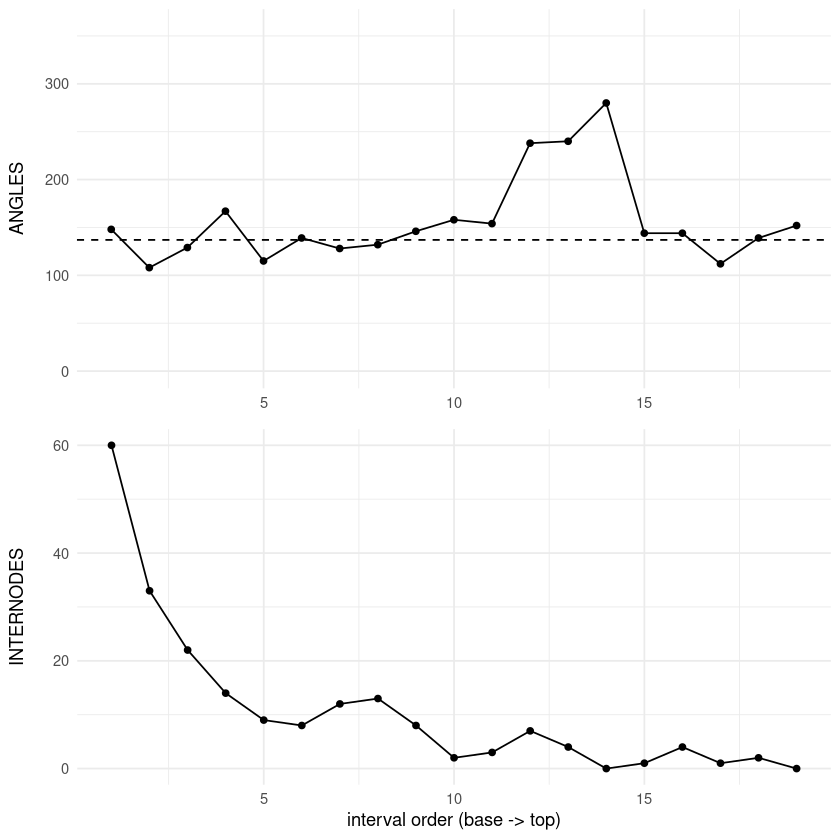

In [12]:
seq_plot(seq.ref)

### Plot the paired sequences without realigning them

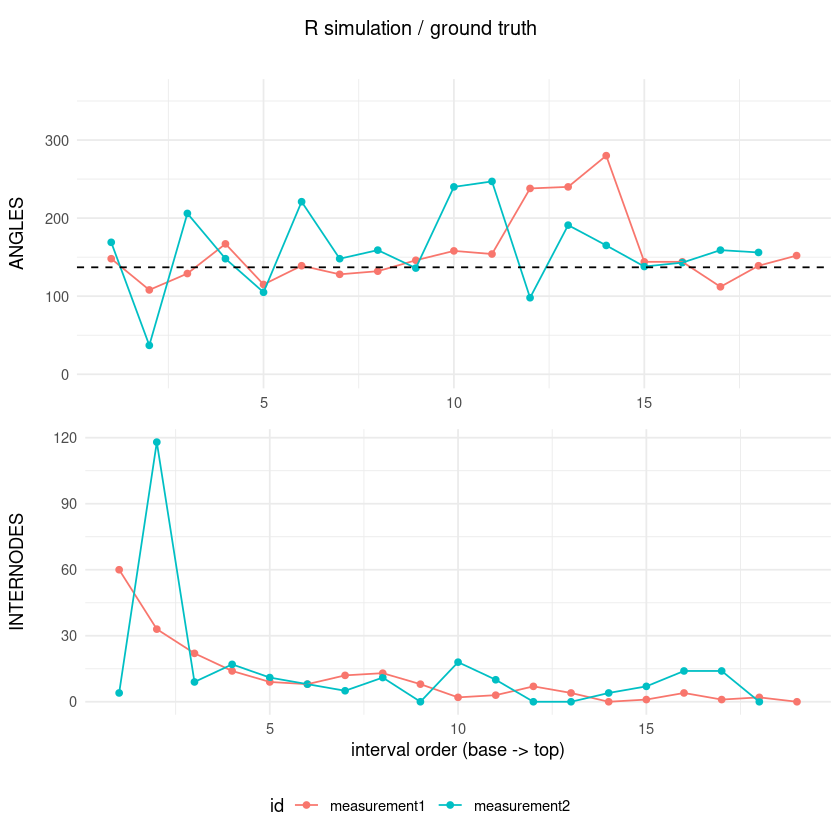

In [13]:
multiseq_plot(list(seq.ref, seq.test$values),  
              id.names=c("measurement1", "measurement2"),
              title="R simulation / ground truth")

### Plot the paired sequences with realignment

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


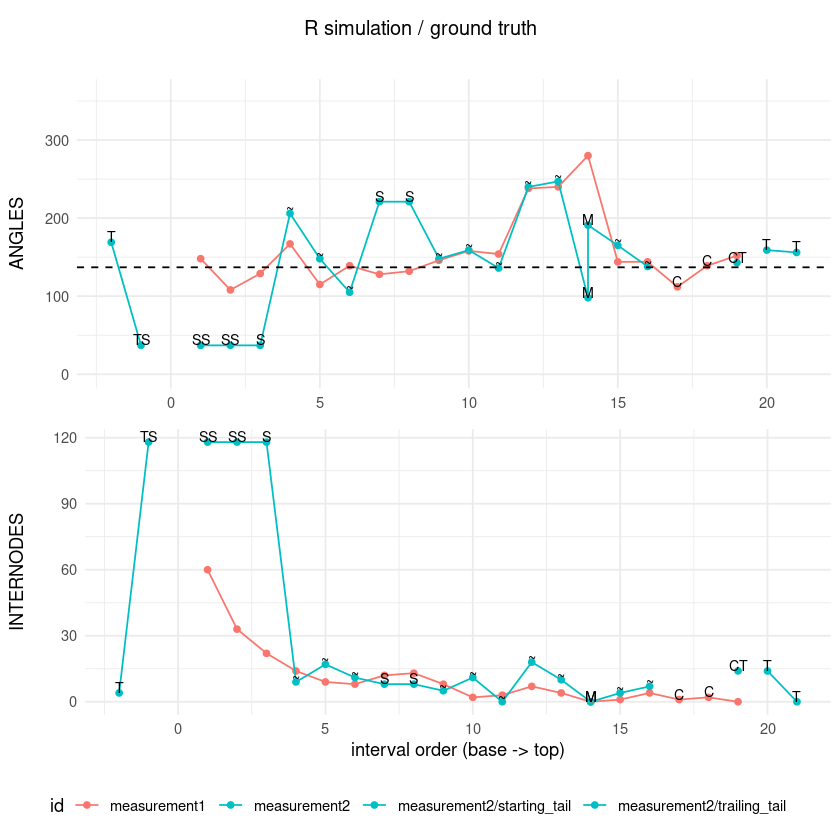

In [14]:
multiseq_plot(list(seq.ref, seq.test$values), 
              align.df = seq.test$I, #Provide the ground truth alignment
              id.names=c("measurement1", "measurement2"),
              title="R simulation / ground truth")

## Write out results to use the simulated paired sequences with `sm-dtw`

In [20]:
#In the generated table, the paired sequences will be attributed to a plantID = "Myplant"
seq.ref.w=cbind.data.frame(plantID=rep("MyPlant", nrow(seq.ref)), #enter here the desired ID for your `plantID`
                             seq.ref[,c(2,3)])
colnames(seq.ref.w)=c("PlantID", "angles", "Internodes")

seq.test.w=cbind.data.frame(plantID=rep("MyPlant", nrow(seq.test$values)), 
                              seq.test$values[,c(2,3)])
colnames(seq.test.w)=c("PlantID", "angles", "Internodes")

align.intervals=cbind.data.frame(PlantID=rep("MyPlant", nrow(seq.test$I)), 
                                                    seq.test$I)
align.organs= cbind.data.frame(PlantID=rep("MyPlant", nrow(seq.test$O)), 
                                                    seq.test$O)
  
write.csv(seq.ref.w, file="../example_data/Notebook_tests/reference_sequences.csv",row.names = FALSE)
write.csv(seq.test.w, file="../example_data/Notebook_tests/test_sequences.csv",row.names = FALSE)  
write.csv(align.intervals, file="../example_data/Notebook_tests/align_intervals.csv",row.names = FALSE)
write.csv(align.organs, file="../example_data/Notebook_tests/align_organs.csv",row.names = FALSE)